# Setting


In [1]:
!pip install ccxt

     |████████████████████████████████| 2.6 MB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 40.5 MB/s 
     |████████████████████████████████| 3.6 MB 29.7 MB/s 
     |████████████████████████████████| 271 kB 52.6 MB/s 
     |████████████████████████████████| 1.1 MB 36.9 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 291 kB 9.4 MB/s 
     |████████████████████████████████| 144 kB 36.8 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import sys, os
import tempfile, urllib, zipfile
import math
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
import time
from datetime import datetime
from google.colab import drive
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.utils import np_utils

import tensorflow as tf
%matplotlib inline

In [3]:
drive.mount('/content/drive')
path_capstone = '/content/drive/MyDrive/Colab Notebooks/capstone/data/'
target_col = 'close'

Mounted at /content/drive


# Data load

In [4]:
#Bitcoin subreddit daily sentiment ratio load
day = pd.read_csv(f'{path_capstone}sent_btc_top.csv')

day.set_index('day', inplace=True)

#make other sentiment features
day['sentMA7'] = day.pos.rolling(window=7, min_periods=7).mean()
day['sentMA25'] = day.pos.rolling(window=25, min_periods=25).mean()

format = '%Y-%m-%d'
day.index = list(map(lambda x: datetime.strptime(x, format), day.index)) 
day

,pos,neu,neg,mean,var,EMA_short,EMA_long,MACD,MACD_OSC,pos-neg,sentMA7,sentMA25
2018-01-03,0.833333,0.000000,0.166667,0.484250,0.151362,0.833333,0.833333,0.000000,-0.833333,0.666667,NaN,NaN
2018-01-04,0.250000,0.166667,0.583333,-0.145250,0.132071,0.517361,0.530449,-0.013088,-0.522347,-0.333333,NaN,NaN
2018-01-05,0.666667,0.060606,0.272727,0.230082,0.181554,0.575635,0.579391,-0.003755,-0.577526,0.393939,NaN,NaN
2018-01-06,0.384615,0.076923,0.538462,-0.035862,0.243944,0.515338,0.524940,-0.009602,-0.519296,-0.153846,NaN,NaN
2018-01-07,0.500000,0.250000,0.250000,0.147825,0.234461,0.511170,0.519156,-0.007986,-0.514796,0.250000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,0.530120,0.156627,0.313253,0.120880,0.185706,0.540750,0.547024,-0.006274,-0.544131,0.216867,0.551938,0.538093
2022-02-25,0.735294,0.147059,0.117647,0.361153,0.215572,0.570680,0.560970,0.009710,-0.567634,0.617647,0.576840,0.545838
2022-02-26,0.571429,0.285714,0.142857,0.197621,0.156034,0.570795,0.561745,0.009050,-0.567111,0.428571,0.563235,0.540362
2022-02-27,0.500000,0.125000,0.375000,0.123629,0.233200,0.559904,0.557171,0.002732,-0.558197,0.125000,0.563235,0.538824


In [5]:
#Crypto subreddit daily sentiment ratio load
crypto_day = pd.read_csv(f'{path_capstone}sent_crypto_top.csv')

crypto_day.set_index('day', inplace=True)

#make other sentiment features
crypto_day['sentMA7'] = crypto_day.pos.rolling(window=7, min_periods=7).mean()
crypto_day['sentMA25'] = crypto_day.pos.rolling(window=25, min_periods=25).mean()

format = '%Y-%m-%d'
crypto_day.index = list(map(lambda x: datetime.strptime(x, format), crypto_day.index)) 
crypto_day

,pos,neu,neg,mean,var,EMA_short,EMA_long,MACD,MACD_OSC,pos-neg,sentMA7,sentMA25
2018-01-03,0.477612,0.134328,0.388060,0.057172,0.214339,0.477612,0.477612,0.000000,-0.477612,0.089552,NaN,NaN
2018-01-04,0.392857,0.285714,0.321429,0.057711,0.200459,0.431703,0.433605,-0.001902,-0.432427,0.071429,NaN,NaN
2018-01-05,0.464646,0.303030,0.232323,0.161424,0.197814,0.444561,0.444758,-0.000197,-0.444707,0.232323,NaN,NaN
2018-01-06,0.508772,0.140351,0.350877,0.115526,0.204538,0.464830,0.462653,0.002177,-0.464102,0.157895,NaN,NaN
2018-01-07,0.581818,0.163636,0.254545,0.159175,0.184012,0.496615,0.490288,0.006327,-0.494322,0.327273,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,0.434146,0.092683,0.473171,0.002051,0.236231,0.552992,0.571855,-0.018863,-0.563860,-0.039024,0.536266,0.587361
2022-02-25,0.566038,0.113208,0.320755,0.140930,0.274857,0.554999,0.571424,-0.016425,-0.565630,0.245283,0.537225,0.585729
2022-02-26,0.679012,0.135802,0.185185,0.263420,0.237684,0.574078,0.579393,-0.005316,-0.580482,0.493827,0.549454,0.584976
2022-02-27,0.600000,0.115789,0.284211,0.142612,0.242103,0.578066,0.580920,-0.002854,-0.582987,0.315789,0.568378,0.585352


In [6]:
#total daily sentiment ratio load
total = pd.read_csv(f'{path_capstone}sent_total.csv')

total.set_index('day', inplace=True)

#make other sentiment features
total['sentMA7'] = total.pos.rolling(window=7, min_periods=7).mean()
total['sentMA25'] = total.pos.rolling(window=25, min_periods=25).mean()

format = '%Y-%m-%d'
total.index = list(map(lambda x: datetime.strptime(x, format), total.index)) 
total

,pos,neu,neg,mean,var,EMA_short,EMA_long,MACD,MACD_OSC,pos-neg,sentMA7,sentMA25
2018-01-03,0.477612,0.134328,0.388060,0.057172,0.214339,0.477612,0.477612,0.000000,-0.477612,0.089552,NaN,NaN
2018-01-04,0.392857,0.285714,0.321429,0.057711,0.200459,0.431703,0.433605,-0.001902,-0.432427,0.071429,NaN,NaN
2018-01-05,0.464646,0.303030,0.232323,0.161424,0.197814,0.444561,0.444758,-0.000197,-0.444707,0.232323,NaN,NaN
2018-01-06,0.508772,0.140351,0.350877,0.115526,0.204538,0.464830,0.462653,0.002177,-0.464102,0.157895,NaN,NaN
2018-01-07,0.581818,0.163636,0.254545,0.159175,0.184012,0.496615,0.490288,0.006327,-0.494322,0.327273,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,0.434146,0.092683,0.473171,0.002051,0.236231,0.552992,0.571855,-0.018863,-0.563860,-0.039024,0.536266,0.587361
2022-02-25,0.566038,0.113208,0.320755,0.140930,0.274857,0.554999,0.571424,-0.016425,-0.565630,0.245283,0.537225,0.585729
2022-02-26,0.679012,0.135802,0.185185,0.263420,0.237684,0.574078,0.579393,-0.005316,-0.580482,0.493827,0.549454,0.584976
2022-02-27,0.600000,0.115789,0.284211,0.142612,0.242103,0.578066,0.580920,-0.002854,-0.582987,0.315789,0.568378,0.585352


#Price data pre-porcessing

In [7]:
def load_price_data():
  t = '2017-12-01 09:00:00' #btc 시작
  start = int(time.mktime(datetime.strptime(t, '%Y-%m-%d %H:%M:%S').timetuple())*1000)#처음 데이터 가져올 때
  def timestamp_to_str(time):  # 타임스탬프 문자열로 변환
      return str(time.year * 100000000 + time.month * 1000000 + time.day * 10000 + time.hour * 100 + time.minute)
  days = 86400000
  binance = ccxt.binance()
  btc_ohlcv = binance.fetch_ohlcv("BTC/USDT", '1d', since = start, limit = 1000)
  btc_ohlcv2 = binance.fetch_ohlcv("BTC/USDT", '1d', since = start + days*1000, limit = 1000)
  df = pd.DataFrame(btc_ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
  df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
  df2 = pd.DataFrame(btc_ohlcv2, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
  df2['datetime'] = pd.to_datetime(df2['datetime'], unit='ms')
  df.set_index('datetime', inplace=True)
  df2.set_index('datetime', inplace=True)

  return df.append(df2)

In [8]:
def make_price_features(hist):
  #Make Features based price data
  hist['fluct'] = (hist['close'] - hist.shift(1)['close'])/hist.shift(1)['close'] *100
  hist['volume_fluct'] = (hist['volume'] - hist.shift(1)['volume'])/hist.shift(1)['volume'] *100
  hist['MA7'] = hist['close'].rolling(window=7, min_periods=1).mean()
  hist['MA25'] = hist['close'].rolling(window=25, min_periods=1).mean()
  hist['MA99'] = hist['close'].rolling(window=99, min_periods=1).mean()
  hist['MA25_volume'] = hist['volume'].rolling(window=99, min_periods=1).mean()
  hist['openRatio'] = (hist['open'] - hist.shift(1)['close'])/hist.shift(1)['close'] *100
  hist['highRatio'] = (hist['high'] - hist.shift(1)['close'])/hist.shift(1)['close'] *100
  hist['lowRatio'] = (hist['low'] - hist.shift(1)['close'])/hist.shift(1)['close'] *100
  hist['estrangementRatio7'] = (hist['MA7'] - hist['close'])/hist['close'] *100 #이격도
  hist['estrangementRatio25'] = (hist['MA25'] - hist['close'])/hist['close'] *100
  hist['estrangementRatio99'] = (hist['MA99'] - hist['close'])/hist['close'] *100
  hist['estrangementRatio25_volume'] = (hist['MA25_volume'] - hist['volume'])/hist['volume'] *100

  hist = hist.dropna(axis=0)
  return hist
  # hist.head(5)

In [9]:
train_ratio = 0.8
val_ratio = 0.2

hist = load_price_data()
train, val = train_test_split(hist, test_size = 1 - train_ratio, shuffle = False)

Train, test 가격 데이터의 패턴이 많이 다르다

In [10]:
def line_plot(line1, line2,  label1, label2,  title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

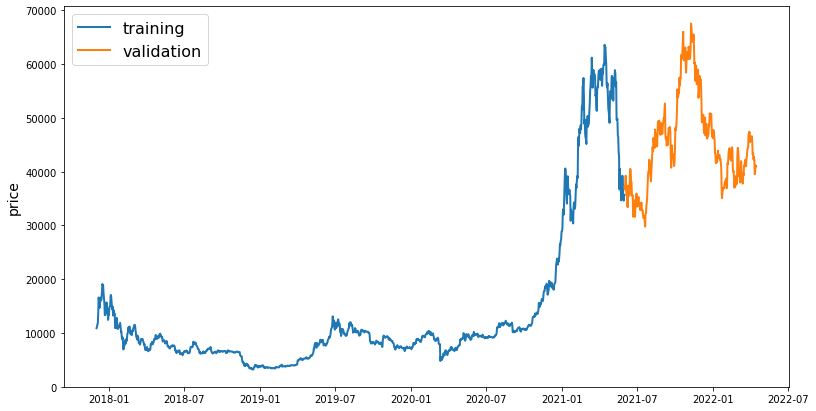

In [11]:
line_plot(train[target_col], val[target_col], 'training', 'validation', title='')

# Model

## def

In [18]:
class Crypto:
  np.random.seed(42)
  test_size = 0.2
  zero_base = True
  lstm_neurons = 100
  epochs = 100
  batch_size = 32
  loss = 'mse'
  dropout = 0.2
  optimizer = 'adam'
  def __init__(self, split, output_size, window, drop_col):
    self.data_split = split
    self.window_len = window
    self.output_size = output_size
    self.eval = []
    self.hist = hist.drop(columns=drop_col, axis=0)


  def extract_window_data(self, df, window_len, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

  def prepare_data(self, df, target_col, window_len, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
    X_train = self.extract_window_data(train_data, window_len, zero_base)
    X_test = self.extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values#ori
    y_test = test_data[target_col][window_len:].values#ori

    return train_data, test_data, X_train, X_test, y_train, y_test


  def build_lstm_model(self, input_data, output_size, neurons=100, activ_func='tanh',
                      dropout=0.2, loss='mse', optimizer='adam'):
      model = Sequential()
      model.add(LSTM(100, input_shape=(input_data.shape[1], input_data.shape[2])))
      model.add(Activation(activ_func))
      model.add(Dropout(dropout))
      # model.add(Dense(50, activation=activ_func))
      # model.add(Dropout(dropout))
      model.add(Dense(units=output_size))
      model.add(Activation('linear'))# output이 regression이므로
      model.compile(loss=loss, optimizer=optimizer)
      return model

  def data_set(self):
      self.trains = []
      self.tests = []
      self.X_trains = []
      self.X_tests = []
      self.y_trains = []
      self.y_tests = []
      train, test, X_train, X_test, y_train, y_test = self.prepare_data(
          self.hist, target_col, window_len=self.window_len, zero_base=self.zero_base, test_size=self.test_size)
      train.drop(target_col, axis = 1, inplace=True)
      self.trains.append(train)
      self.tests.append(test)
      self.X_trains.append(X_train)
      self.X_tests.append(X_test)
      self.y_trains.append(y_train)
      self.y_tests.append(y_test)


  def train_model(self, order):
    early_stopping = EarlyStopping(monitor = 'val_loss', patience=100)
    self.model = self.build_lstm_model(
        self.X_trains[order], output_size,neurons=self.lstm_neurons, dropout=self.dropout, loss=self.loss,
        optimizer=self.optimizer)
    self.history = self.model.fit(
        self.X_trains[order], self.y_trains[order], validation_data=(self.X_tests[order], self.y_tests[order]), epochs=self.epochs, batch_size = self.batch_size, verbose=1, shuffle=True,
        callbacks=[early_stopping])
    print(self.model.summary())
  
  def evaluate(self, order):
    self.train_model(order)
    self.preds = self.model.predict(self.X_tests[order]).squeeze()
    MAE = mean_absolute_error(self.preds, self.y_tests[order])
    MSE = mean_squared_error(self.preds, self.y_tests[order])
    RMSE = math.sqrt(MSE)
    R2 = r2_score(self.y_tests[order], self.preds)

    return MAE, RMSE, R2

  def visualization(self, order):
    print(f'Epochs:{self.epochs}, batch_size:{self.batch_size}, DropOut:{self.dropout}')
    print(f'Feature:{self.hist.columns}, target_col:{target_col}')
    
    targets =  scaler1.inverse_transform(self.tests[order][target_col][self.window_len:].values.reshape(-1,1))

    preds = scaler1.inverse_transform(np.reshape(self.preds, (-1,1)))
    line_plot(targets, preds, 'actual', 'prediction', title = 'prcie_predction', lw=3)
    plt.show()

    plt.plot(self.history.history['loss'],'r',linewidth=2, label='Train loss')
    plt.plot(self.history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
    plt.title('LSTM')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

  def conditions(self):
    return self.hist.columns, 'dropout:',self.dropout, 'window_size:', self.window_len


In [19]:
def execute(split, output_size, drop_col, window_size):
  crypto_obj = Crypto(split, output_size, window_size, drop_col)
  crypto_obj.data_set()
  maes = []
  rmses = []
  r2s = []

  mae, rmse, r2 = crypto_obj.evaluate(0)
  maes.append(mae)
  rmses.append(rmse)
  r2s.append(r2)
  crypto_obj.visualization(0)
  
  condition = crypto_obj.conditions()

  print(f'MAE:{maes} RMSE:{rmses} R2:{r2s}')
  print(condition)
  return rmse


## TEST

### scaling

In [20]:
price = make_price_features(load_price_data())

In [21]:
hist = total.join(price, how='outer')
hist.dropna(inplace = True)
scaler = MinMaxScaler()
hist[['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25','open', 'high', 'low',  'volume',
      'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume']] =  scaler.fit_transform(hist[['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25','open', 'high', 'low',  'volume',
      'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume']])
scaler1 = MinMaxScaler()
# hist['close'] = scaler1.fit_transform(hist['close'])
hist['close'] = scaler1.fit_transform(hist['close'].values.reshape(-1,1))


### close

Epoch 1/100
36/36 [==============================] - 8s 39ms/step - loss: 0.0112 - val_loss: 0.0024
Epoch 2/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 3/100
36/36 [==============================] - 0s 11ms/step - loss: 8.9597e-04 - val_loss: 0.0023
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 5/100
36/36 [==============================] - 0s 10ms/step - loss: 9.0754e-04 - val_loss: 0.0017
Epoch 6/100
36/36 [==============================] - 0s 11ms/step - loss: 8.3925e-04 - val_loss: 0.0016
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 8.0214e-04 - val_loss: 0.0021
Epoch 8/100
36/36 [==============================] - 0s 11ms/step - loss: 7.8376e-04 - val_loss: 0.0023
Epoch 9/100
36/36 [==============================] - 0s 10ms/step - loss: 6.5940e-04 - val_loss: 0.0021
Epoch 10/100
36/36 [==============================] - 0s 11ms/step - loss: 7.1

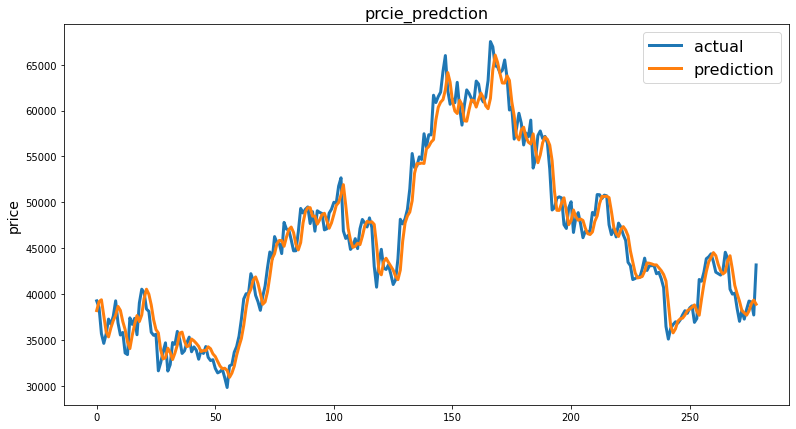

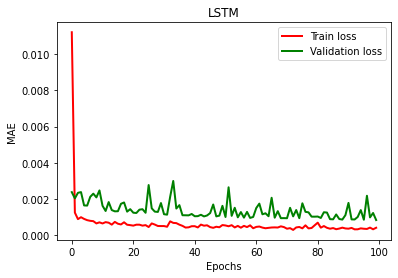

MAE:[0.022458637834159707] RMSE:[0.02907501903982326] R2:[0.9582977814303328]
(Index(['close'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0166 - val_loss: 0.0022
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 8.1600e-04 - val_loss: 0.0021
Epoch 5/100
36/36 [==============================] - 0s 6ms/step - loss: 8.6579e-04 - val_loss: 0.0015
Epoch 6/100
36/36 [==============================] - 0s 6ms/step - loss: 8.5568e-04 - val_loss: 0.0020
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 7.5351e-04 - val_loss: 0.0016
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 7.1347e-04 - val_loss: 0.0021
Epoch 9/100
36/36 [===================

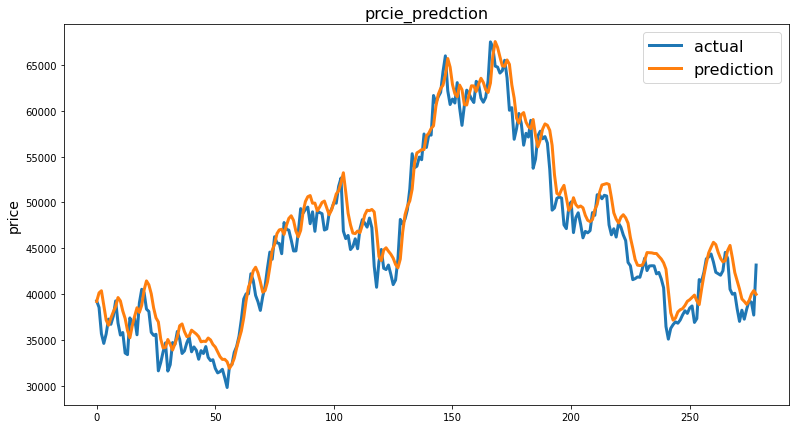

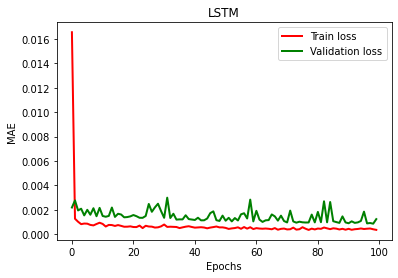

MAE:[0.02780584576343268] RMSE:[0.03504590901164868] R2:[0.9394109974798199]
(Index(['close'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0201 - val_loss: 0.0021
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 9.5060e-04 - val_loss: 0.0018
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 8.5780e-04 - val_loss: 0.0017
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 9.1532e-04 - val_loss: 0.0019
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 8.3587e-04 - val_loss: 0.0015
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 7.9239e-04 - val_loss: 0.0015
Epoch 9/100
36/36 [====================

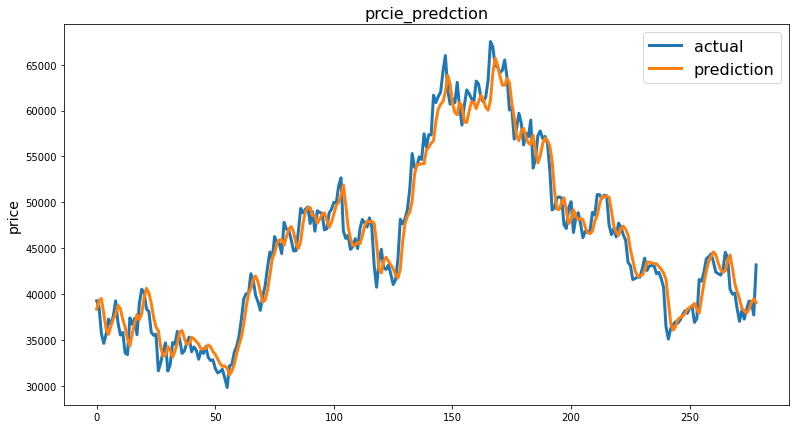

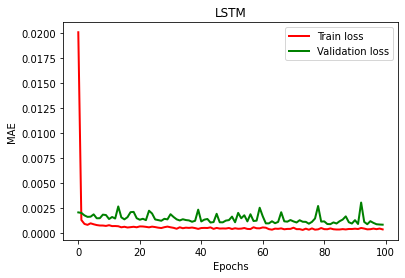

MAE:[0.02289021877355594] RMSE:[0.02957345899318574] R2:[0.9568557034759839]
(Index(['close'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 31ms/step - loss: 0.0120 - val_loss: 0.0020
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 8.9056e-04 - val_loss: 0.0015
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 9.2968e-04 - val_loss: 0.0023
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 8.2860e-04 - val_loss: 0.0018
Epoch 6/100
36/36 [==============================] - 0s 6ms/step - loss: 7.9145e-04 - val_loss: 0.0017
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 8.2285e-04 - val_loss: 0.0014
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 7.0167e-04 - val_loss: 0.0016
Epoch 9/100
36/36 [================

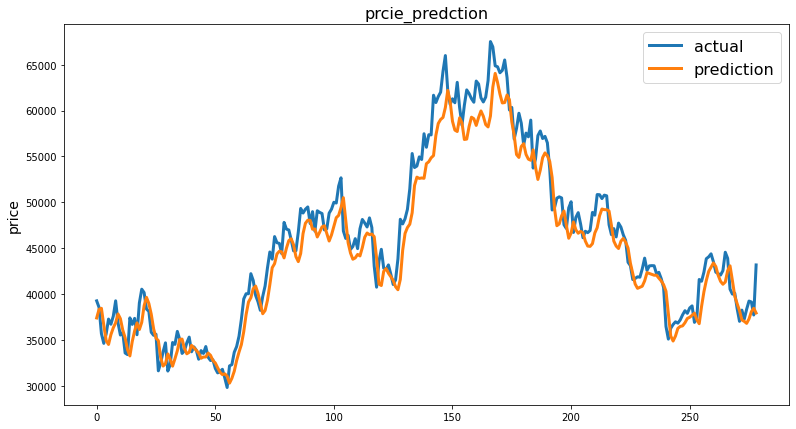

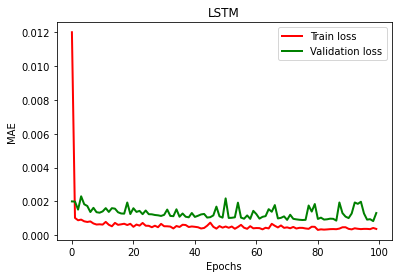

MAE:[0.028899085895239256] RMSE:[0.03630569755018633] R2:[0.9349767436109031]
(Index(['close'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0163 - val_loss: 0.0020
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 9.9121e-04 - val_loss: 0.0018
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 6.9107e-04 - val_loss: 0.0018
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 8.0467e-04 - val_loss: 0.0016
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 9.3878e-04 - val_loss: 0.0016
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 8.4889e-04 - val_loss: 0.0015
Epoch 8/100
36/36 [==============================] - 0s 8ms/step - loss: 6.8223e-04 - val_loss: 0.0015
Epoch 9/100
36/36 [===============

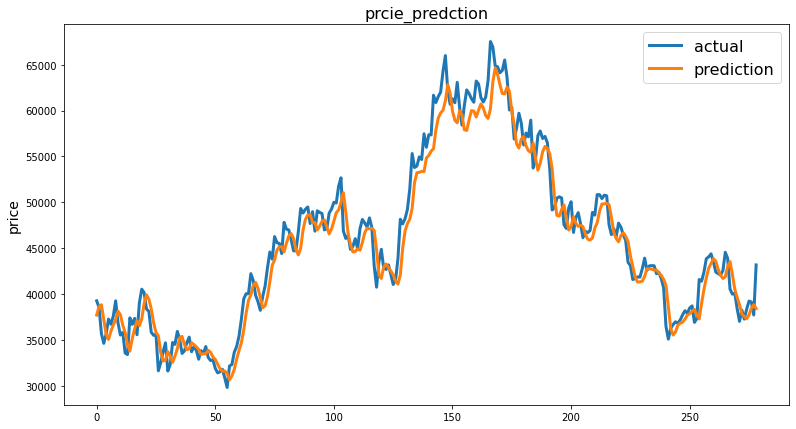

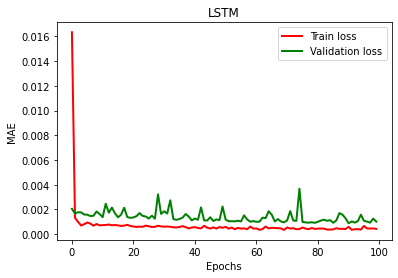

MAE:[0.02512774998640987] RMSE:[0.03184311881717581] R2:[0.9499792338629935]
(Index(['close'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Minimal RMSE:0.02907501903982326


In [22]:
#close
rmse = 100
for i in range(5):
  
  window_size = 5
  split = 1
  output_size = 1
  drop_col = ['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
        'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25','open', 'high', 'low', 'volume',
        'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
        'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
        'estrangementRatio25', 'estrangementRatio99',
        'estrangementRatio25_volume']

  rmse = min(execute(split, output_size, drop_col, window_size),rmse)
print(f'Minimal RMSE:{rmse}')

### ohlcv + fluct

Epoch 1/100
36/36 [==============================] - 6s 34ms/step - loss: 0.0137 - val_loss: 0.0016
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 7/100
36/36 [==============================] - 0s 6ms/step - loss: 8.7414e-04 - val_loss: 0.0014
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 9.7203e-04 - val_loss: 0.0015
Epoch 9/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/100
36/36 [==============================] - 0s 7ms/step - loss: 7.1104e-04 - val_loss: 0.0

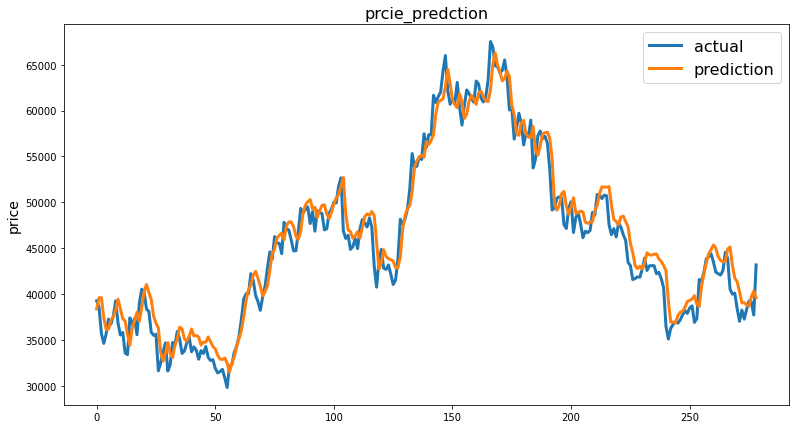

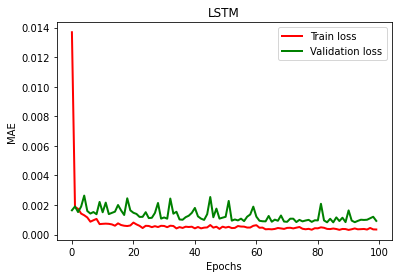

MAE:[0.023798147241650316] RMSE:[0.0304679306666478] R2:[0.9542063709479429]
(Index(['open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 22ms/step - loss: 0.0125 - val_loss: 0.0016
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 7/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 9.9421e-04 - val_loss: 0.0014
Epoch 9/100
3

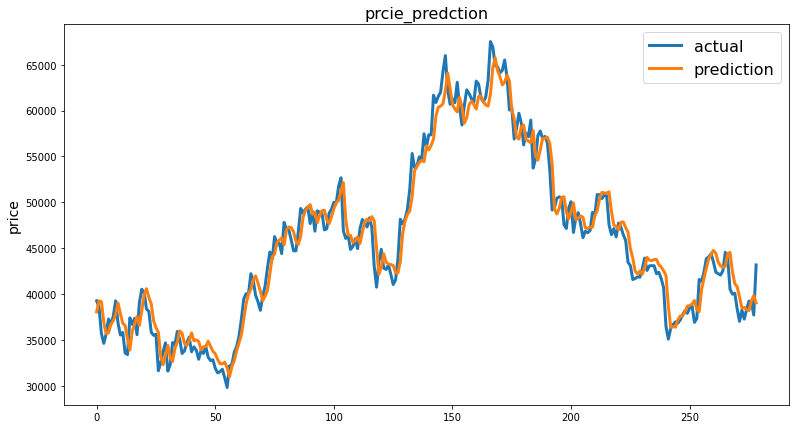

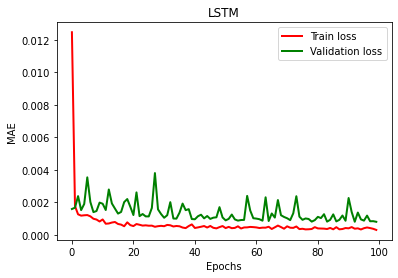

MAE:[0.021778180182889774] RMSE:[0.02841609395294301] R2:[0.9601665516449607]
(Index(['open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 31ms/step - loss: 0.0107 - val_loss: 0.0037
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 9.4151e-04 - val_loss: 0.0018
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 8.4314e-04 - val_loss: 0.0014
Epoch 9/

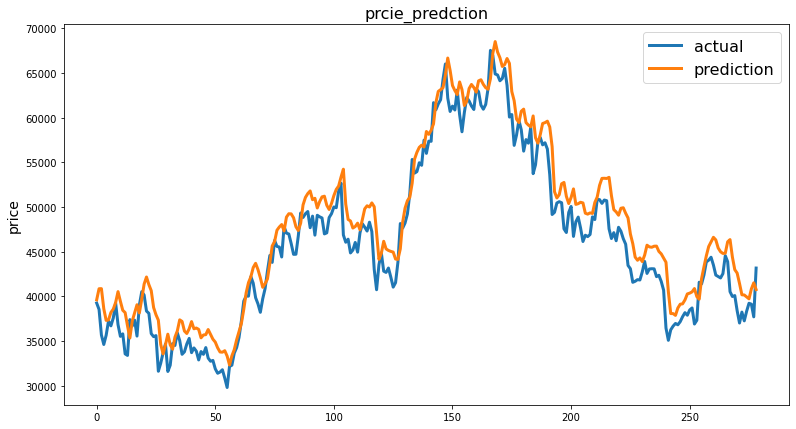

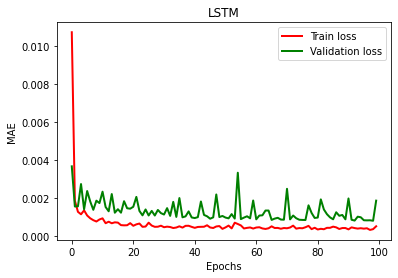

MAE:[0.036146038955720154] RMSE:[0.04325087273139221] R2:[0.9077197218169069]
(Index(['open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0082 - val_loss: 0.0015
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 9.3178e-04 - val_loss: 0.0014
Epoch 7/100
36/36 [==============================] - 0s 6ms/step - loss: 8.5776e-04 - val_loss: 0.0017
Epoch 8/100
36/36 [==============================] - 0s 8ms/step - loss: 8.5335e-04 - val_loss: 0.0014
Epoc

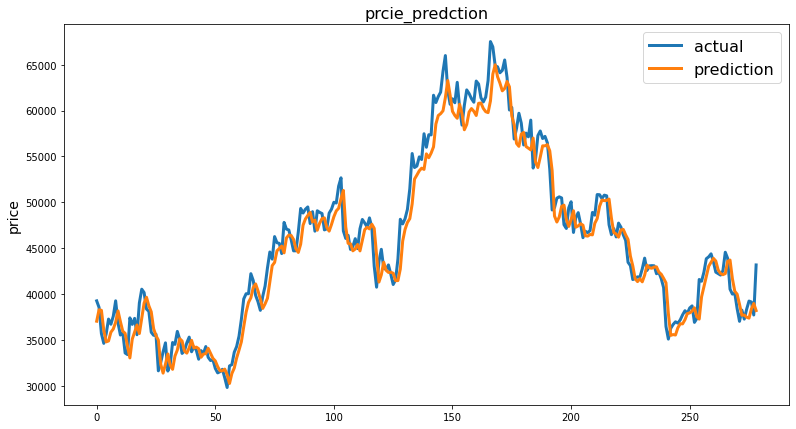

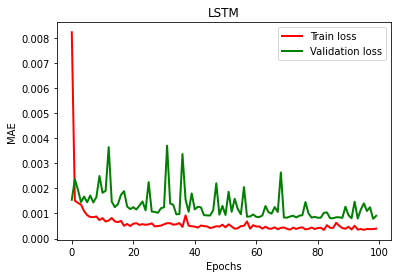

MAE:[0.023718354095840933] RMSE:[0.03011695867530914] R2:[0.9552553236918774]
(Index(['open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0093 - val_loss: 0.0020
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 9.0191e-04 - val_loss: 0.0019
Epoch 8/100
36/36 [==============================] - 0s 8ms/step - loss: 9.0261e-04 - val_loss: 0.0013
Epoch 9/

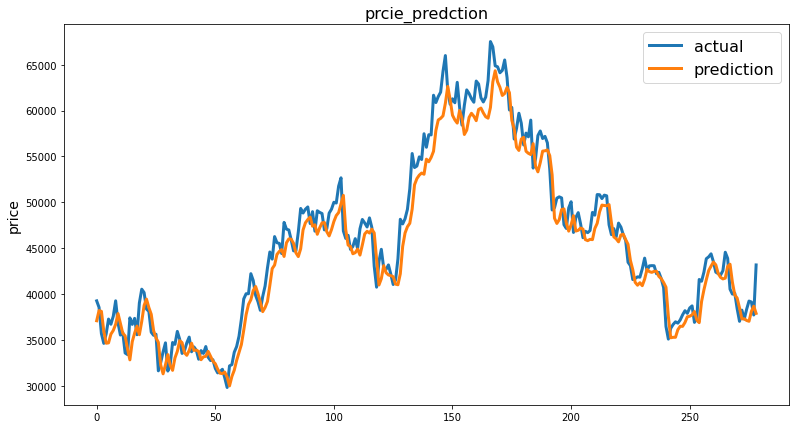

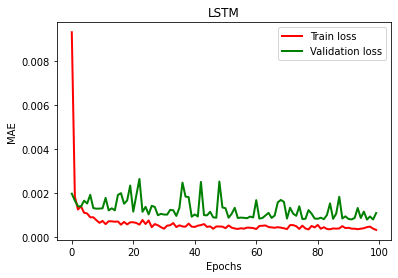

MAE:[0.026398638855898847] RMSE:[0.03308160844715564] R2:[0.9460126042203854]
(Index(['open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Minimal RMSE:0.02841609395294301


In [28]:
#ohlcv + fluct
rmse = 100
for i in range(5):
  
  window_size = 5
  split = 1
  output_size = 1
  drop_col = ['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
        'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25',
        'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
        'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
        'estrangementRatio25', 'estrangementRatio99',
        'estrangementRatio25_volume']

  rmse = min(execute(split, output_size, drop_col, window_size),rmse)
print(f'Minimal RMSE:{rmse}')

### Total:ohlcv + fluct + pos

Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0107 - val_loss: 0.0035
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 7/100
36/36 [==============================] - 0s 6ms/step - loss: 9.1057e-04 - val_loss: 0.0014
Epoch 8/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 9/100
36/36 [==============================] - 0s 6ms/step - loss: 7.2387e-04 - val_loss: 0.0014
Epoch 10/100
36/36 [==============================] - 0s 6ms/step - loss: 9.3842e-04 - val_loss: 0.0

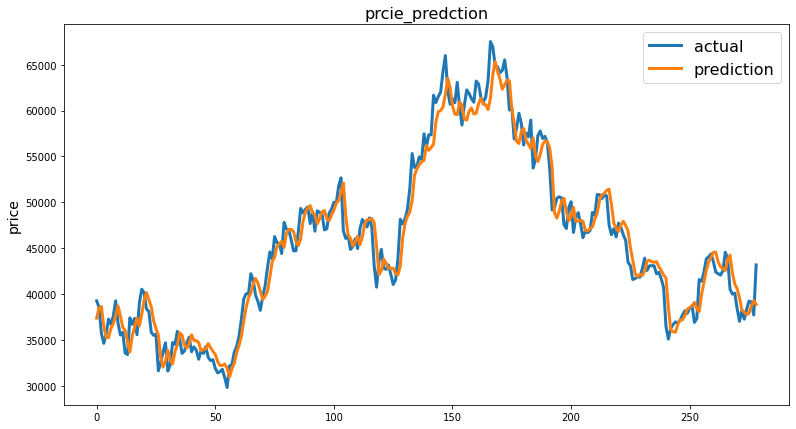

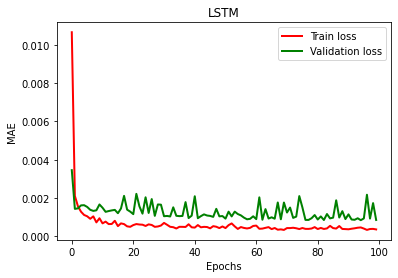

MAE:[0.022676921861605397] RMSE:[0.029155458708552365] R2:[0.9580667134484786]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0133 - val_loss: 0.0024
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 9.5297e-04 - val_loss: 0.0014
Epoch 8/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0017
Epoc

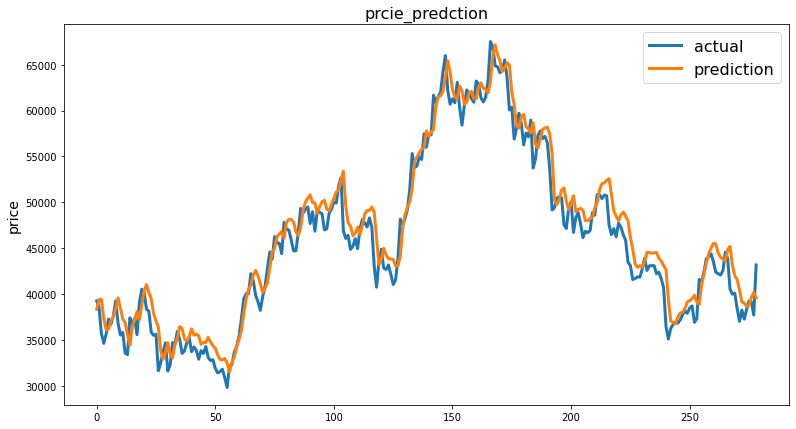

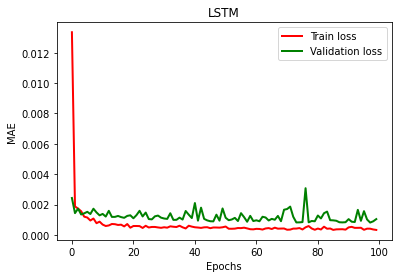

MAE:[0.02536860264728676] RMSE:[0.03232743471748672] R2:[0.9484460873574427]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 7s 37ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 2/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 5/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/100
36/36 [==============================] - 0s 6ms/step - loss: 9.4279e-04 - val_loss: 0.0013
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 8.1166e-04 - val_loss: 0.0026
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 8.0932e-04 - val_loss: 0.0

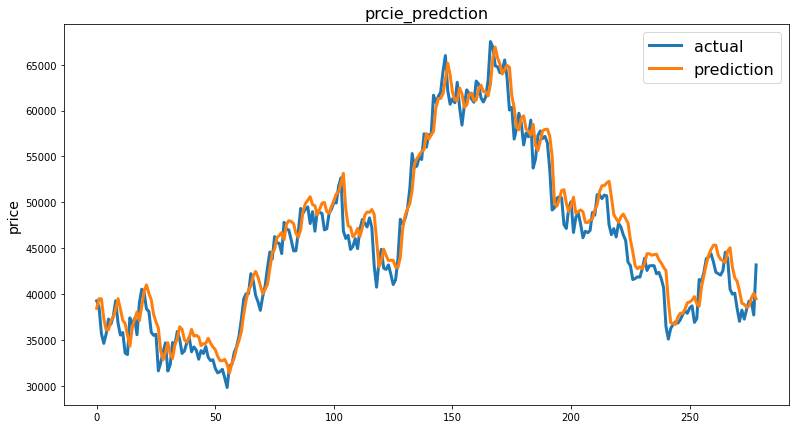

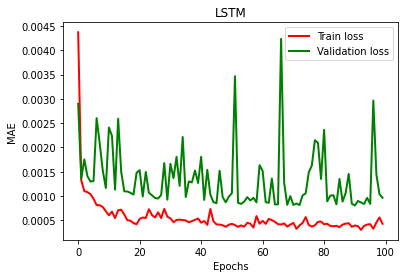

MAE:[0.024156814431696778] RMSE:[0.031036895197000917] R2:[0.9524800818381086]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 7.6741e-04 - val_loss: 0.0013
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 8.4844e-04 - val_loss: 0.0013


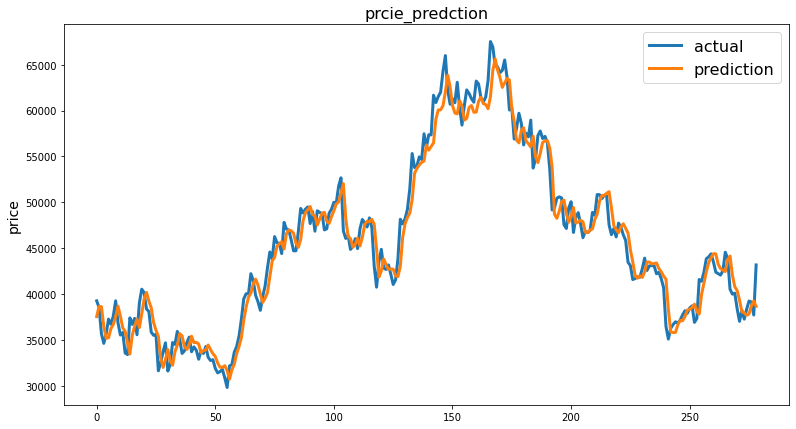

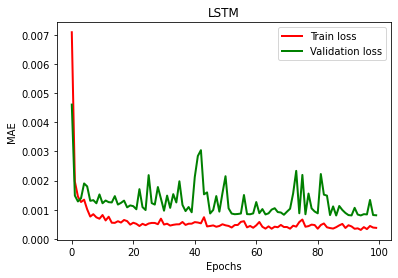

MAE:[0.022058598241148933] RMSE:[0.028485237172962998] R2:[0.9599724670025799]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0150 - val_loss: 0.0020
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 9.8788e-04 - val_loss: 0.0014
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 8.0899e-04 - val_loss: 0.0023
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 9.1020e-04 - val_loss: 0.0

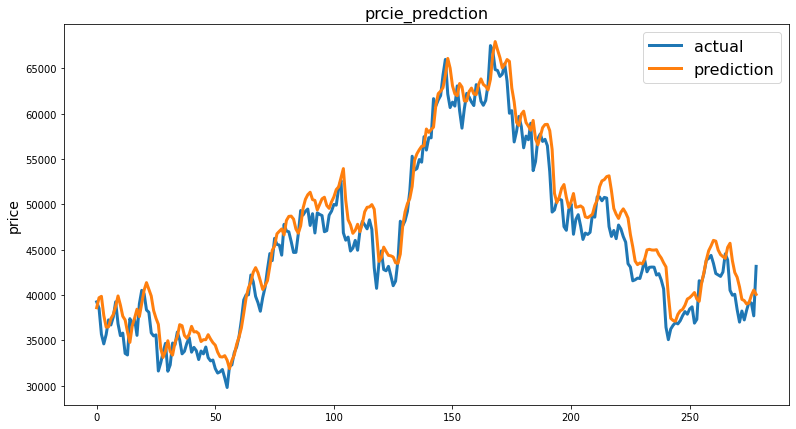

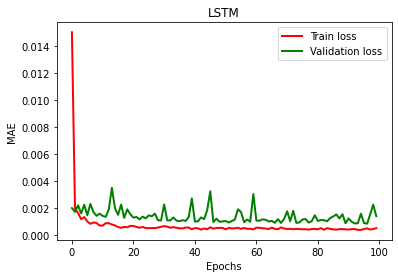

MAE:[0.029819756828883423] RMSE:[0.03713486443795186] R2:[0.931972763266776]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Minimal RMSE:0.028485237172962998


In [24]:
#Total: ohlcv + fluct + pos
rmse = 100
for i in range(5):
  
  window_size = 5
  split = 1
  output_size = 1
  drop_col = ['neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
        'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25',
        'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
        'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
        'estrangementRatio25', 'estrangementRatio99',
        'estrangementRatio25_volume']

  rmse = min(execute(split, output_size, drop_col, window_size),rmse)
print(f'Minimal RMSE:{rmse}')

### crypto: ohlcv + fluct + pos

In [25]:
hist = crypto_day.join(price, how='outer')
hist.dropna(inplace = True)
scaler = MinMaxScaler()
hist[['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25','open', 'high', 'low',  'volume',
      'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume']] =  scaler.fit_transform(hist[['pos', 'neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25','open', 'high', 'low',  'volume',
      'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume']])
scaler1 = MinMaxScaler()
# hist['close'] = scaler1.fit_transform(hist['close'])
hist['close'] = scaler1.fit_transform(hist['close'].values.reshape(-1,1))


Epoch 1/100
36/36 [==============================] - 3s 32ms/step - loss: 0.0138 - val_loss: 0.0015
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 9.0270e-04 - val_loss: 0.0019
Epoch 9/100
36/36 [==============================] - 0s 6ms/step - loss: 8.6547e-04 - val_loss: 0.0013
Epoch 10/100
36/36 [==============================] - 0s 7ms/step - loss: 8.0747e-04 - val_loss: 0.0

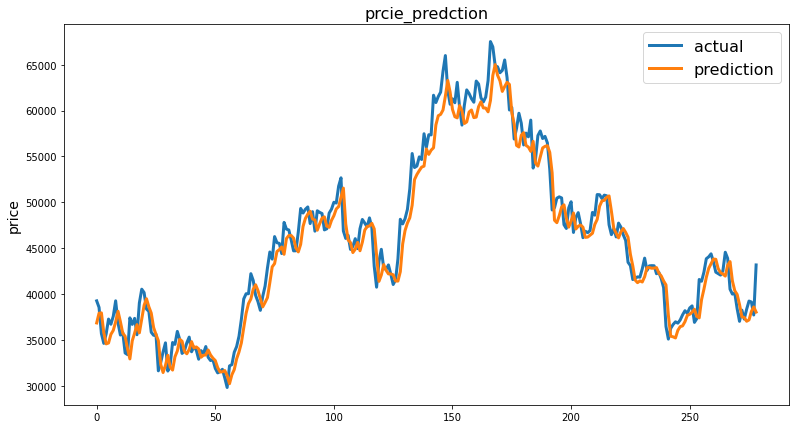

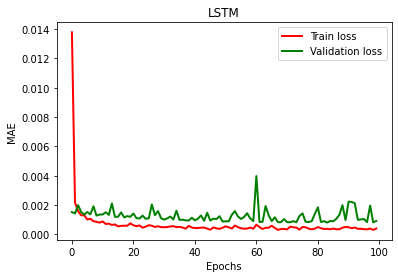

MAE:[0.024074473302616313] RMSE:[0.030354348508595905] R2:[0.9545471649564711]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 22ms/step - loss: 0.0058 - val_loss: 0.0030
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 9.7284e-04 - val_loss: 0.0013
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 8.3247e-04 - val_loss: 0.0018
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 8.6350e-04 - val_loss: 0.0013
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 7.9076e-04 - val_loss: 0.0014
Epoch 8/100
36/36 [==============================] - 0s 8ms/step - loss: 7.8648e-04 - val_l

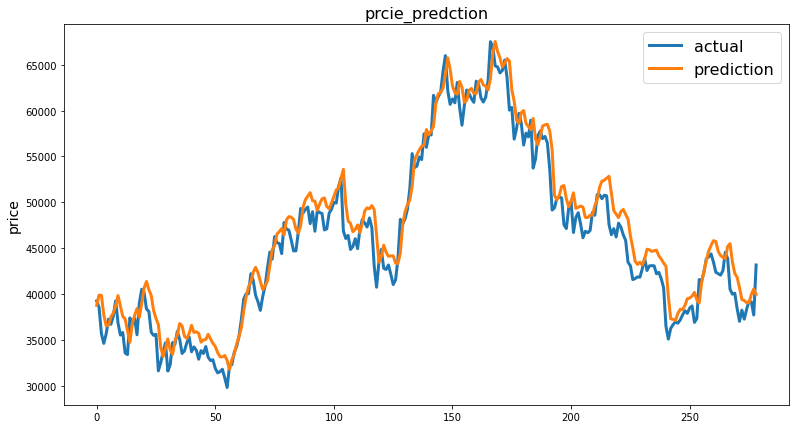

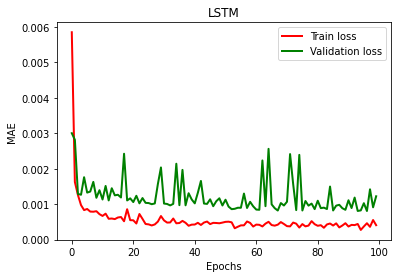

MAE:[0.027807357603337225] RMSE:[0.034954975285002056] R2:[0.9397250105033785]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 21ms/step - loss: 0.0139 - val_loss: 0.0016
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 5/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/100
36/36 [==============================] - 0s 6ms/step - loss: 8.0507e-04 - val_loss: 0.0013
Epoc

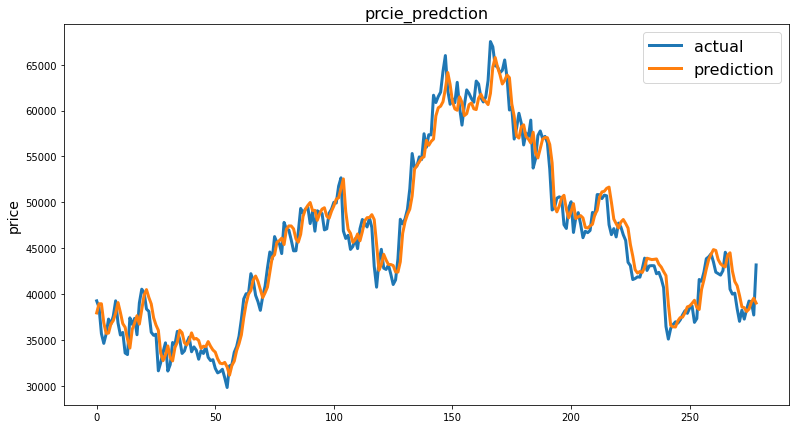

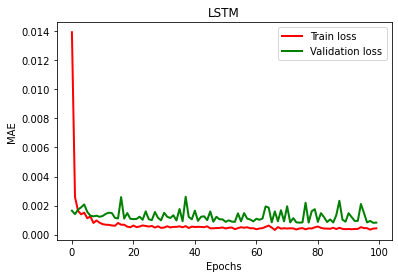

MAE:[0.021976767304810452] RMSE:[0.028745642118655646] R2:[0.9592372783567374]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 22ms/step - loss: 0.0078 - val_loss: 0.0016
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 6/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 9.0565e-04 - val_loss: 0.0013
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 7.4544e-04 - val_loss: 0.0014


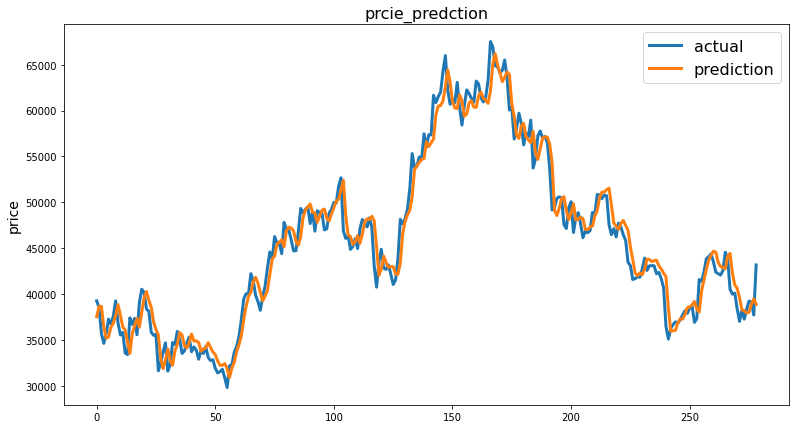

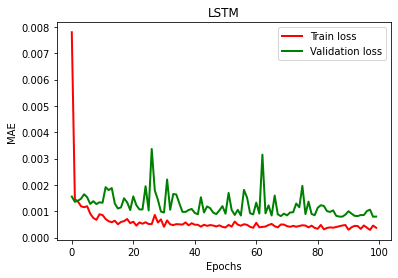

MAE:[0.021634817765383355] RMSE:[0.028224391332083022] R2:[0.9607021930747064]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Epoch 1/100
36/36 [==============================] - 3s 22ms/step - loss: 0.0173 - val_loss: 0.0025
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 9/

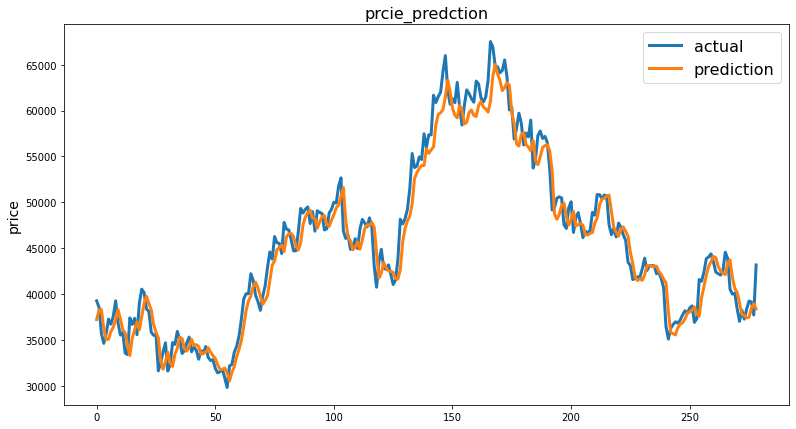

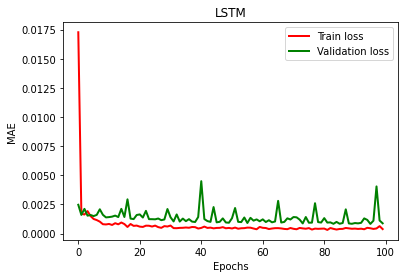

MAE:[0.023282565425218785] RMSE:[0.029615267489852] R2:[0.9567336296118663]
(Index(['pos', 'open', 'high', 'low', 'close', 'volume', 'fluct'], dtype='object'), 'dropout:', 0.2, 'window_size:', 5)
Minimal RMSE:0.028224391332083022


In [26]:
#Crypto: ohlcv + fluct + pos
rmse = 100
for i in range(5):
  
  window_size = 5
  split = 1
  output_size = 1
  drop_col = ['neu', 'neg', 'mean', 'var', 'EMA_short', 'EMA_long', 'MACD',
        'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25',
        'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
        'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
        'estrangementRatio25', 'estrangementRatio99',
        'estrangementRatio25_volume']

  rmse = min(execute(split, output_size, drop_col, window_size),rmse)
print(f'Minimal RMSE:{rmse}')

sentiment 모델 성능 향상 비교(minimal RMSE)

In [29]:
(0.02841609395294301 - 0.028224391332083022)/0.028224391332083022 *100

0.6792090522146215